In [1]:
import numpy as np
import pandas as pd
import statsrat as sr
from statsrat import latent_cause as lc
from statsrat.expr.predef.pvl_no_iti import blocking as task
from plotnine import *

In [2]:
#model = lc.model(name = 'constant', kernel = lc.kernel.constant)
model = lc.model(name = 'power', kernel = lc.kernel.power)
print(model.pars)
save_plots = True

method = 'local_vb'
#method = 'particle'
perform_oat = False

prior_tau2_x = 2.0
prior_nu_x = 2.0
prior_tau2_y = 0.5
prior_nu_y = 2.0
alpha = 2.0
stick = 0.0
power = 2.0

par_vals = {'constant': [prior_tau2_x, prior_nu_x, prior_tau2_y, prior_nu_y, stick, alpha, 5.0],
            'power': [power, prior_tau2_x, prior_nu_x, prior_tau2_y, prior_nu_y, stick, alpha, 5.0]}

               min   max  default  \
power         0.00   5.0      1.0   
prior_tau2_x  0.01  10.0      1.0   
prior_nu_x    1.00  10.0      5.0   
prior_tau2_y  0.01  10.0      1.0   
prior_nu_y    1.00  10.0      5.0   
stick         0.00   5.0      1.0   
alpha         0.00  15.0      1.0   
resp_scale    0.00  10.0      1.0   

                                                    description  
power         decay rate for power law SCRP; higher -> favor...  
prior_tau2_x                 prior hyperparameter for eta for x  
prior_nu_x                   prior hyperparameter for eta for x  
prior_tau2_y                 prior hyperparameter for eta for y  
prior_nu_y                   prior hyperparameter for eta for y  
stick                                  stickiness for CRP prior  
alpha         concentration parameter; higher -> tend to inf...  
resp_scale           scales softmax/logistic response functions  


blocking 

experimental
[[0.90604414 0.71578757 0.90939559]
 [0.         0.32501074 0.32501074]]
[0 0 0 0 0 0 0 0 0 0 1 1]
ex  ctx.cs1  ctx.cs1.cs2  ctx.cs2
z                                
0         5            5        0
1         0            0        2

control
[[0.80202113 0.83959577 0.83959577]
 [0.         0.27686891 0.27686891]]
[0 0 0 0 0 1 1]
ex  ctx.cs1.cs2  ctx.cs2
z                       
0             5        0
1             0        2


/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4.0 x 4.0 in image.
/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: plots/latent_cause_blocking_b_power.jpeg


0.038381611377156566
       schedule      trial_name u_name  mean_resp
0       control  cs2 -> nothing     us   0.881807
0  experimental  cs2 -> nothing     us   0.843425


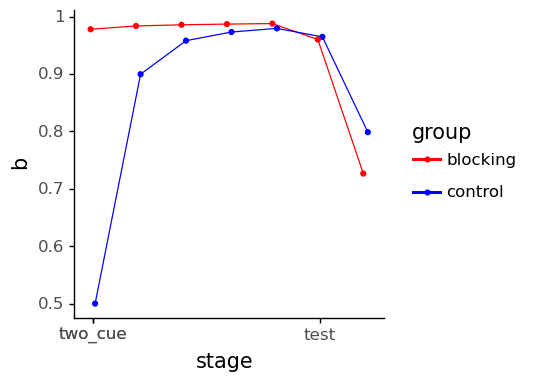

In [3]:
print('blocking \n')

trials_exp = task.make_trials('experimental')
trials_ctl = task.make_trials('control')
sel = [{'t': trials_exp['stage_name'].isin(['two_cue', 'test'])}, None]
t_max_exp = trials_exp['t'].max()
t_max_ctl = trials_ctl['t'].max()

if method == 'particle':
    ds_exp = model.particle_filter(trials_exp, par_vals[model.name], n_p = 100)
    ds_ctl = model.particle_filter(trials_ctl, par_vals[model.name], n_p = 100)
    #sr.multi_plot([ds_exp, ds_ctl], var = 'b', only_main = True, sel = sel, dodge_width = 0.1).draw()
    #sr.multi_plot([ds_exp, ds_ctl], var = 'mean_N', sel = sel, dodge_width = 0.1).draw()
else:
    ds_exp = model.simulate(trials_exp, par_vals[model.name])
    ds_ctl = model.simulate(trials_ctl, par_vals[model.name])
    #sr.multi_plot([ds_exp, ds_ctl], var = 'b', only_main = True, sel = sel, dodge_width = 0.1).draw()
    #sr.multi_plot([ds_exp, ds_ctl], var = 'N', sel = sel, dodge_width = 0.1).draw()
    print('experimental')
    print(ds_exp.loc[{'t': t_max_exp, 'z_name': ['0', '1']}]['est_mu_x'].values)
    df_exp = ds_exp['z'].to_dataframe()
    table_exp = pd.crosstab(df_exp['z'], df_exp['ex'])
    print(ds_exp['z'].values)
    print(table_exp)
    print('\ncontrol')
    print(ds_ctl.loc[{'t': t_max_ctl, 'z_name': ['0', '1']}]['est_mu_x'].values)
    df_ctl = ds_ctl['z'].to_dataframe()
    table_ctl = pd.crosstab(df_ctl['z'], df_ctl['ex'])
    print(ds_ctl['z'].values)
    print(table_ctl)
    
plot_b = sr.multi_plot([ds_exp, ds_ctl],
                        var = 'b',
                        draw_points = True,
                        dodge_width = 0.2,
                        rename_coords = {'schedule': 'group'},
                        rename_schedules = {'control': 'control', 'experimental': 'blocking'},
                        sel = [{'t': ds_exp['stage_name'].isin(['two_cue', 'test'])}, None])
plot_b += scale_color_manual(values = {'blocking': 'red', 'control': 'blue'})
plot_b.draw()
if save_plots:
    plot_b.save(filename = 'plots/latent_cause_blocking_b_' + model.name + '.jpeg', dpi = 500)

oat_name = list(task.oats.keys())[0]
print(task.oats[oat_name].compute_total({'experimental': ds_exp, 'control': ds_ctl}))
print(task.oats[oat_name].mean_resp({'experimental': ds_exp, 'control': ds_ctl}))

In [4]:
if perform_oat:
    n_dict = {'local_vb': 1, 'particle': 10}
    oat_result = sr.perform_oat(model = model,
                                experiment = task,
                                n = n_dict[method],
                                minimize = False,
                                sim_type = method,
                                max_time = 300)
    print(np.round(oat_result[0], 4))
    print(np.round(oat_result[1], 4))

In [5]:
if perform_oat:    
    print('blocking (maximum value) \n')

    max_pars = list(oat_result[0].loc['max', model.par_names[0:-1]]) + [5.0]
    if method == 'particle':
        ds_exp = model.particle_filter(trials_exp, par_val = max_pars, n_p = 50)
        ds_ctl = model.particle_filter(trials_ctl, par_val = max_pars, n_p = 50)
        sr.multi_plot([ds_exp, ds_ctl], var = 'b', only_main = True, sel = sel).draw()
        sr.multi_plot([ds_exp, ds_ctl], var = 'mean_N', sel = sel).draw()
    else:
        ds_exp = model.simulate(trials_exp, par_val = max_pars)
        ds_ctl = model.simulate(trials_ctl, par_val = max_pars)
        sr.multi_plot([ds_exp, ds_ctl], var = 'b', only_main = True, sel = sel).draw()
        sr.multi_plot([ds_exp, ds_ctl], var = 'N', sel = sel).draw()
        print('experimental')
        df_exp = ds_exp['z'].to_dataframe()
        table_exp = pd.crosstab(df_exp['z'], df_exp['ex'])
        print(ds_exp['z'].values)
        print(table_exp)
        print('\ncontrol')
        df_ctl = ds_ctl['z'].to_dataframe()
        table_ctl = pd.crosstab(df_ctl['z'], df_ctl['ex'])
        print(ds_ctl['z'].values)
        print(table_ctl)

    oat_name = list(task.oats.keys())[0]
    print(task.oats[oat_name].compute_total({'experimental': ds_exp, 'control': ds_ctl}))
    print(task.oats[oat_name].mean_resp({'experimental': ds_exp, 'control': ds_ctl}))
    
    foo = oat_result[2]['experimental']
    print(foo['b'].loc[{'t': foo['stage_name'] == 'test'}].mean())
    print(foo['stage_name'].values)